# ODEs and BCs
## ODEs
$$\frac{dy_{0}}{dx}=y_{1}$$
$$\frac{dy_{1}}{dx}=(-(K_{1}+K_{2})y_{0}-\gamma_{1}y_{1}+K_{2}y_{2})$$
$$\frac{dy_{2}}{dx}=y_{3}$$
$$\frac{dy_{3}}{dx}=(K_{2}y_{0}-K_{2}y_{2}-\gamma_{2}y_{3})$$
## BCs
### Left Boundary (x=0):
$$y_{0}=1.0$$
$$y_{1}=0.5$$
$$y_{2}=0$$
### Right Boundary (x=20):
$$y_{3}=1.0$$

In [1]:
# -*- coding: utf-8 -*-
"""
@Author: Guan-Fu Liu
Date: June 15, 2022
Version: 0.0
To slove boundary value problem (BVP) of 4 independent varibles with relaxation method.
"""
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import time

start = time.time() # The time of the beginning
ne = 4 # The number of the ODEs.
mesh = 1000 # The number of mesh points.
nl = 3 # The number of boundary conditions of the left.
nr = ne - nl # The number of boundary conditions of the right.
itmax = 100 # The maximum number of iterations.
y0 = np.ones((ne,mesh),dtype=complex)
# An initial guess of y.
y = y0
x = np.linspace(0, 20, mesh) # The meshed points of x.
# K1 = k1/m1
# K2 = k2/m2
m1, k1, gamma1 = 1.0, 10.0, 0.5
m2, k2, gamma2 = 2.0, 40.0, 0.25

# Generate the matrix

In [2]:
def difeq(ne,mesh,nl,nr,x,y):
    """
    Here, this function generates the matrix and error column that the relaxation method needs.
    This function should be modified according to the BVP you need to solve.
    A \Delta y = -E
    """
    A = np.zeros((ne*mesh,ne*mesh),dtype=complex)
    E = np.zeros(ne*mesh,dtype=complex)
    for i in range(ne*mesh):
        # Left boundary
        if i < nl:
            A[0,0:ne:1] = np.array([1,0,0,0])
            E[0] = y[0,0]-1
            
            A[1,0:ne:1] = np.array([0,1,0,0])
            E[1] = y[1,0]-0.5  
            
            A[2,0:ne:1] = np.array([0,0,1,0])
            E[2] = y[2,0]-0.0
            
        # Intermediate points
        elif i>= nl and i < ne*mesh - nr:
            k = (i-nl)//ne + 1 
            h = x[k]-x[k-1]
            
            if (i-nl)%ne == 0:
                A[i,ne*k-ne:ne*k-ne+2*ne:1] = np.array([-1,-0.5*h,0,0,
                                                        1,-0.5*h,0,0])
                E[i] = y[0,k]-y[0,k-1]-0.5*h*(y[1,k]+y[1,k-1])
                
            elif (i-nl)%ne == 1:
                A[i,ne*k-ne:ne*k-ne+2*ne:1] = np.array([0.5*h*(k1+k2)/m1,-1+0.5*h*gamma1/m1,-0.5*h*k2/m1,0,
                                                        0.5*h*(k1+k2)/m1, 1+0.5*h*gamma1/m1,-0.5*h*k2/m1,0])
                E[i] = y[1,k]-y[1,k-1]-0.5*h/m1*(-(k1+k2)*(y[0,k]+y[0,k-1])-gamma1*(y[1,k]+y[1,k-1])
                                                 +k2*(y[2,k]+y[2,k-1]))    
                
            elif (i-nl)%ne == 2:
                A[i,ne*k-ne:ne*k-ne+2*ne:1] = np.array([0,0,-1,-0.5*h,
                                                        0,0,1, -0.5*h])
                E[i] = y[2,k]-y[2,k-1]-0.5*h*(y[3,k]+y[3,k-1])    
                
            else:
                A[i,ne*k-ne:ne*k-ne+2*ne:1] = np.array([-0.5*h*k2/m2,0,0.5*h*k2/m2,-1+0.5*h*gamma2/m2,
                                                        -0.5*h*k2/m2,0,0.5*h*k2/m2,1+0.5*h*gamma2/m2])
                E[i] = y[3,k]-y[3,k-1]-0.5*h/m2*(k2*(y[0,k-1]+y[0,k])-k2*(y[2,k-1]+y[2,k])
                                                 -gamma2*(y[3,k-1]+y[3,k]))                  
            
        # Right boundary
        else:
            A[-nr,-ne::1] = np.array([0,0,0,1])
            E[-nr] = y[3,-1]-1
    return A, -E

# Solve the linear equations. Here, scipy.sparse.linalg.spsolve must be used. Numpy.linalg.solve is too slow.

In [3]:
slowc = 1000
scalv = np.array([1.0,1.0,1.0,1.0])
conv = 5e-15
scale_adaptive = False
for i in range(itmax):
    A, E = difeq(ne,mesh,nl,nr,x,y)
    A = scipy.sparse.csr_matrix(A)
    Delta_y = scipy.sparse.linalg.spsolve(A, E)
    Delta_y = np.reshape(Delta_y,(ne,mesh),order='F')
    E = np.reshape(E,(ne,mesh),order='F')
    # Here, I introduced the adaptive definition of scalv.
    # The typical scale of each component of y is defined
    # as their mean absolute value in the previous iteration.
    # To avoid the division by zero, the initial value of scalv
    # is the lower bound of scalv.
    if scale_adaptive:
        scalv = np.maximum(scalv, np.abs(y).mean(axis=1))
    else:
        pass
    # Original definition of error is as follows,
    # which depends on the delta y.
    # err = np.array([Delta_y[j]/scalv[j] for j in range(len(scalv))])
    # err = np.abs(err).sum()/mesh/ne

    # New definition of error
    err = np.array([E[j]/scalv[j] for j in range(len(scalv))])
    err = np.abs(err).sum()/mesh/ne
    fraction = slowc/max(slowc,err)
    if i==0:
        print("       iteration    error           fraction ")
    print("%8d            %0.6e    %0.6e"%(i+1,err,fraction))
    if err < conv:
        print(' The BVP is solved successfully!')
        break
    elif err >= conv and i <=itmax-1:
        y = y + fraction*Delta_y
        continue
    else:
        print(" Exceed the maximum number of iterations!")
    

end = time.time() # The time of the end.
print("\n The total time of this programme is %0.2e seconds"%(end-start))

       iteration    error           fraction 
       1            6.350000e-02    1.000000e+00
       2            3.332125e-16    1.000000e+00
 The BVP is solved successfully!

 The total time of this programme is 1.38e+00 seconds


# Plot $y_{0}$, $y_{1}$, $y_{2}$, $y_{3}$. 

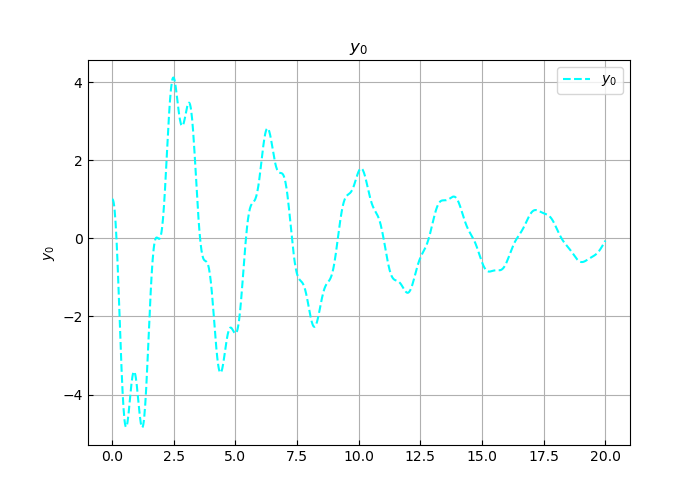

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.plot(x,np.real(y[0]),linestyle='--',color='cyan',label=r'$y_{0}$')
ax.set_ylabel(r'$y_{0}$')
ax.set_title(r'$y_{0}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.savefig('y0.png',dpi=100)

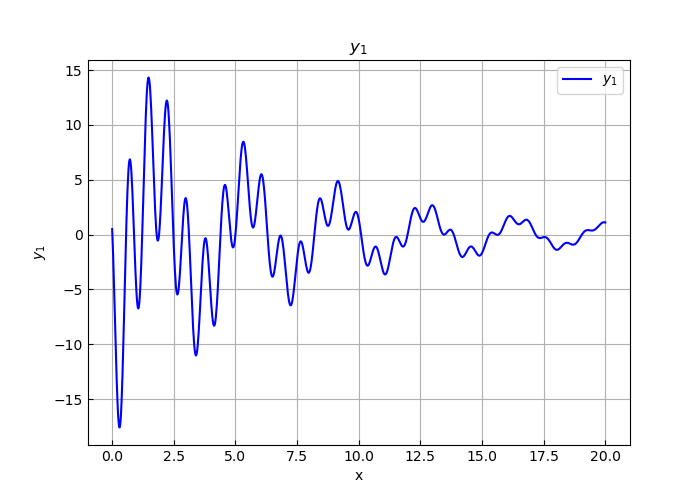

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.plot(x,np.real(y[1]),linestyle='-',color='blue',label=r'$y_{1}$')
ax.set_xlabel('x')
ax.set_ylabel(r'$y_{1}$')
ax.set_title(r'$y_{1}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.savefig('y1.png',dpi=100)

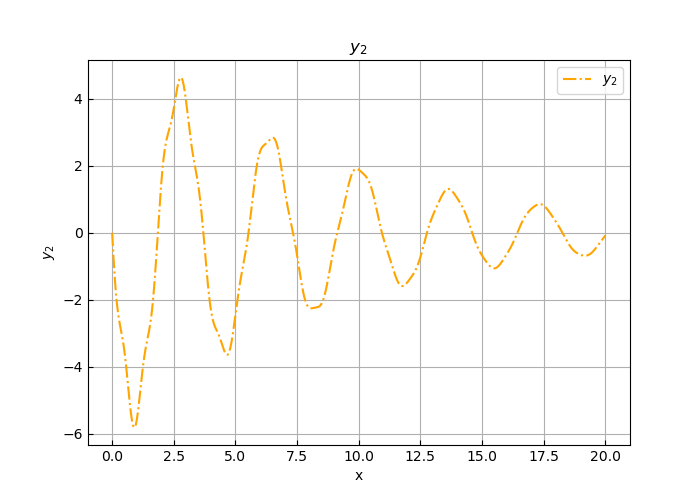

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.plot(x,np.real(y[2]),linestyle='-.',color='orange',label=r'$y_{2}$')
ax.set_xlabel('x')
ax.set_ylabel(r'$y_{2}$')
ax.set_title(r'$y_{2}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.savefig('y2.png',dpi=100)

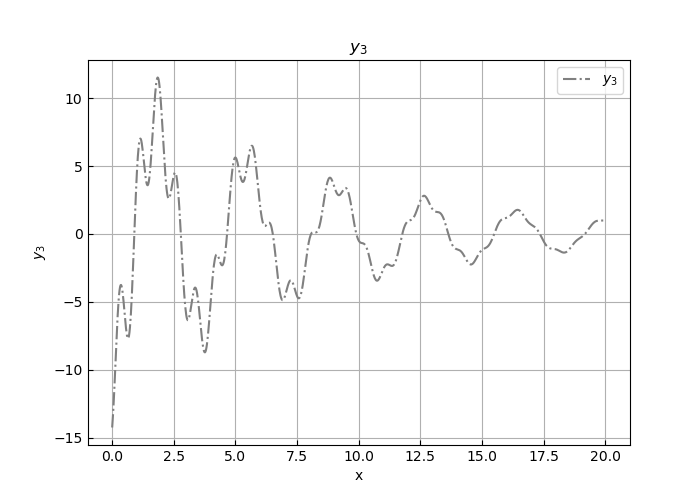

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.plot(x,np.real(y[3]),linestyle='-.',color='grey',label=r'$y_{3}$')
ax.set_xlabel('x')
ax.set_ylabel(r'$y_{3}$')
ax.set_title(r'$y_{3}$')
ax.legend()
ax.grid()
ax.tick_params(direction='in')
fig.savefig('y3.png',dpi=100)

# Check the boundary conditions
## In the left boundary (x=0): $y_{0}=1$, $y_{1}=0.5$, $y_{2}=0$
## In the right boundary (x=20): $y_{3}=1$

In [15]:
print('Left boundary: y0(x=0) = {0[0]:.2f}, y1(x=0) = {0[1]:.2f}, y2(x=0) = {0[2]:.2f}'.format(y[:3,0]))
print('Right boundary: y3(x=20) = {0:.2f}'.format(y[3,-1]))

Left boundary: y0(x=0) = 1.00+0.00j, y1(x=0) = 0.50+0.00j, y2(x=0) = 0.00+0.00j
Right boundary: y3(x=20) = 1.00+0.00j
